In [1]:
# import packages
import librosa
from librosa.display import specshow
import python_speech_features
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# audio file path
audio_file = 'sample.wav'

In [3]:
# samples from audio file
samples,sample_rate = librosa.core.load(audio_file,sr=16000, mono= True)

In [4]:
samples.shape #it returns a tuple indicating the number of elements along each dimension of the array.

(476480,)

In [5]:
# Timeline of audio file with samples
time_line = np.arange(0,len(samples))/sample_rate
#Dividing by the sample rate converts the indices to time values, giving us the time points corresponding to each sample.

In [6]:
print(time_line)
#contain an array representing the timeline of the audio file, where each element corresponds to a specific time point in seconds

[0.00000000e+00 6.25000000e-05 1.25000000e-04 ... 2.97798125e+01
 2.97798750e+01 2.97799375e+01]


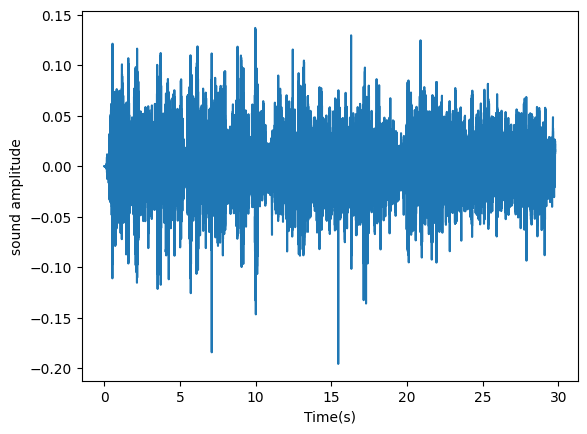

In [7]:
# plot samples
fig, ax = plt.subplots()
ax.plot(time_line,samples)
ax.set(xlabel='Time(s)',ylabel='sound amplitude')
plt.show()

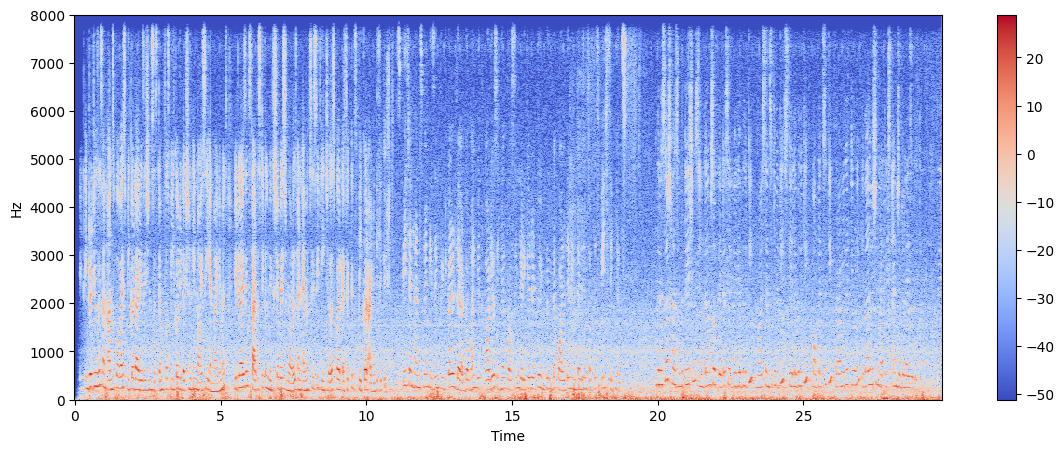

In [8]:
#display Spectrogram
X = librosa.stft(samples)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
specshow(Xdb, sr=sample_rate, x_axis='time', y_axis='hz') 
plt.colorbar()

In [9]:
# Set the step size (in seconds) between consecutive frames for feature extraction
winstep = 0.01  # happens to be the default value

# Compute Mel-Frequency Cepstral Coefficients (MFCC) features
# The fbank function computes Mel filterbank features from the audio samples
# signal: Audio samples
# samplerate: Sample rate of the audio signal
# winstep: Step size (in seconds) between consecutive frames
# nfilt: Number of Mel filters to use in the filterbank
features, energy = python_speech_features.fbank(signal=samples, samplerate=sample_rate, winstep=winstep, nfilt=26)


In [10]:
features.shape
#if the MFCC features are computed for a 10-second audio signal with a frame rate of 100 frames per second and 
#13 MFCC coefficients extracted per frame, executing features.shape would return (1000,13)

(2977, 26)

In [11]:
# Calculate the frame rate (frames per second) using the step size between consecutive frames
frame_rate = 1. / winstep

# Compute the timeline corresponding to each frame of MFCC features
# np.arange(0, len(features)) creates an array of indices representing each frame
# len(features) indicates the total number of frames
# Each frame corresponds to a specific time point in seconds, so we divide by the frame rate to convert indices to time values
timeline_mfcc = np.arange(0, len(features)) / frame_rate

In [12]:
print(timeline_mfcc)
#contains the time values corresponding to each frame of MFCC features. Each value in the array represents a specific time point in seconds.

[0.000e+00 1.000e-02 2.000e-02 ... 2.974e+01 2.975e+01 2.976e+01]


In [13]:
from spectralcluster import SpectralClusterer

In [14]:
# Initialize SpectralClusterer without unsupported parameters
# The SpectralClusterer is a clustering algorithm used for speaker diarization
# Here, we initialize it with minimum and maximum cluster parameters
# min_clusters: Minimum number of clusters to consider
# max_clusters: Maximum number of clusters to consider
clusterer = SpectralClusterer(
    min_clusters=2,  # Minimum number of clusters
    max_clusters=100)  # Maximum number of clusters

# Predict cluster labels for the MFCC features using the SpectralClusterer
# The predict() method assigns each frame of MFCC features to a cluster
labels = clusterer.predict(features)

c:\Users\geeth\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\geeth\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\geeth\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\geeth\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  

In [15]:
print(labels)
#contains the cluster labels assigned to each frame of MFCC features by the SpectralClusterer. Each label corresponds to a specific cluster or speaker identity.

[14 15 15 ... 10 16  1]


In [16]:
len(labels)

2977

In [17]:
set(labels)

{0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26}

In [18]:
# Create a dictionary to map time points to cluster labels
# This dictionary will store the time (in seconds) as keys and the corresponding cluster labels as values
# We use a dictionary comprehension to iterate over pairs of time points and cluster labels
# zip(timeline_mfcc, labels) pairs each time point with its corresponding cluster label
# We convert the time value to a string to use it as the dictionary key, and we convert the cluster label to an integer
labels_timeline = {str(time): int(label) for (time, label) in zip(timeline_mfcc, labels)}

In [20]:
# Initialize lists to store the beginning and end times of speaker segments, and segment labels
begin = list()  # List to store beginning times
end = list()    # List to store end times
segment = list()  # List to store segment labels

# Initialize status variables to track speaker segments
status_0 = True  # Status variable for Speaker-0
status_1 = True  # Status variable for Speaker-1

# Extract time points from the dictionary keys
time_list = list(labels_timeline.keys())  

# Iterate over each time point and its corresponding cluster label
for index, (time, label) in enumerate(labels_timeline.items()):
    # Check if the current cluster label is 0 (Speaker-0)
    if label == 0:
        # Check if status_0 is True (indicating the start of a new segment)
        if status_0:
            # Append the current time to the list of beginning times
            begin.append(float(time))
            # Append the segment label (Speaker-0) to the list of segment labels
            segment.append(f"Speaker-{label}")
            # Check if status_1 is False (indicating the end of the previous Speaker-1 segment)
            if not status_1:
                # Append the previous time (end of Speaker-1 segment) to the list of end times
                end.append(float(time_list[index-1]))
            # Update status_0 and status_1
            status_0 = False
            status_1 = True
    # Check if the current cluster label is 1 (Speaker-1)
    elif label == 1:
        # Check if status_1 is True (indicating the start of a new segment)
        if status_1:
            # Append the current time to the list of beginning times
            begin.append(float(time))
            # Append the segment label (Speaker-1) to the list of segment labels
            segment.append(f"Speaker-{label}")
            # Check if status_0 is False (indicating the end of the previous Speaker-0 segment)
            if not status_0:
                # Append the previous time (end of Speaker-0 segment) to the list of end times
                end.append(float(time_list[index-1]))
            # Update status_1 and status_0
            status_1 = False
            status_0 = True
    # Check if the current index is the last one
    if index == len(time_list)-1:
        # Append the current time to the list of end times (end of the last segment)
        end.append(float(time))

In [21]:
begin #Initialize lists to store the beginning and end times of speaker segments, and segment labels

[0.05,
 0.12,
 0.27,
 2.61,
 3.51,
 3.65,
 3.68,
 4.11,
 4.21,
 4.7,
 5.3,
 6.02,
 6.97,
 7.33,
 7.64,
 8.57,
 9.79,
 9.82,
 10.22,
 10.24,
 10.46,
 12.26,
 12.7,
 13.37,
 17.24,
 17.39,
 17.4,
 17.97,
 20.47,
 25.49,
 28.39,
 28.96,
 29.76]

In [22]:
end

[0.11,
 0.26,
 2.6,
 3.5,
 3.64,
 3.67,
 4.1,
 4.2,
 4.69,
 5.29,
 6.01,
 6.96,
 7.32,
 7.63,
 8.56,
 9.78,
 9.81,
 10.21,
 10.23,
 10.45,
 12.25,
 12.69,
 13.36,
 17.23,
 17.38,
 17.39,
 17.96,
 20.46,
 25.48,
 28.38,
 28.95,
 29.75,
 29.76]

In [23]:
segment

['Speaker-1',
 'Speaker-0',
 'Speaker-1',
 'Speaker-0',
 'Speaker-1',
 'Speaker-0',
 'Speaker-1',
 'Speaker-0',
 'Speaker-1',
 'Speaker-0',
 'Speaker-1',
 'Speaker-0',
 'Speaker-1',
 'Speaker-0',
 'Speaker-1',
 'Speaker-0',
 'Speaker-1',
 'Speaker-0',
 'Speaker-1',
 'Speaker-0',
 'Speaker-1',
 'Speaker-0',
 'Speaker-1',
 'Speaker-0',
 'Speaker-1',
 'Speaker-0',
 'Speaker-1',
 'Speaker-0',
 'Speaker-1',
 'Speaker-0',
 'Speaker-1',
 'Speaker-0',
 'Speaker-1']

In [24]:
import altair as alt
import datetime as dt
import pandas as pd

# Enable Altair rendering in JupyterLab
alt.renderers.enable('jupyterlab')

# Create a DataFrame to hold the speaker segment data
data = pd.DataFrame()
data['from'] = begin
data['to'] = end
data['Speaker'] = segment

# Create an Altair chart to visualize the speaker segments
alt.Chart(data).mark_bar().encode(
    x='from',  # X-axis: start time of each segment
    x2='to',   # X2-axis: end time of each segment
    y='Speaker',  # Y-axis: Speaker label
    color=alt.Color('Speaker', scale=alt.Scale(scheme='dark2'))  # Color encoding for each speaker
)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting
